# DL: Benchmark Table

In this notebook, we build a benchmark table using the built-in models from [StarDist](https://github.com/stardist/stardist) and [Cellpose](https://github.com/mouseLand/cellpose) as well as our trained models from the previous notebook **Training Stardist and Cellpose Models**.

The first section shows how to obtain the predictions from our custom trained models.
The second section includes the code for building the table, using `seaborn` and `matplotlib`. 

## Evaluate a custom model

### 1. StarDist
In this section, we show how to get predictions from the StarDist model that we had trained. 

Many of it is similar to the contents of **DL: StarDist and Cellpose**. 
You can skip to the next section to find the code for building the benchmark table.

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env TF_CPP_MIN_LOG_LEVEL=3

#Built-in 
import warnings
import logging
import sys
from pathlib import Path

#Ignoring warnings for notebook compilation
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

#Bioimageloader and Albumentation
import albumentations as A
from bioimageloader import Config, BatchDataloader
from bioimageloader.transforms import SqueezeGrayImageHWC, HWCToCHW

#Stardist and Tensorflow
import tensorflow as tf
from stardist.matching import matching, matching_dataset
from stardist.models import StarDist2D

#Cellpose and Torch
import torch
from cellpose import models as cellpose_models

#Other imports
#!pip install matplotlib seaborn pandas tqdm numpy
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

env: CUDA_VISIBLE_DEVICES=0
env: TF_FORCE_GPU_ALLOW_GROWTH='true'


In [2]:
# setting 'TF_FORCE_GPU_ALLOW_GROWTH' does not actually limit
# gpu memory, it allows to grow. we have to manually limit memory usage
if gpus := tf.config.list_physical_devices('GPU'):
    for gpu in gpus:
        try:
            vdc = tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=2000
            )
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [vdc]
            )
        except RuntimeError as e:
            print(e)
# see what devices you have (set)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We load the datasets together using a config file and apply transformations. We invert ComPath and LIVECell as we had trained our model with them inverted.

In [3]:
cfg_all_collections = Config('configs/instanceseg.yml') 
transforms = A.Compose([
    A.Resize(256, 256),
    SqueezeGrayImageHWC() 
])
transforms_invert = A.Compose([
    A.InvertImg(p=1.0),
    SqueezeGrayImageHWC()
])

cfg_transforms = {
    'DSB2018': transforms,
    'ComputationalPathology': transforms_invert,  
    'S_BSST265': transforms,
    'FRUNet': transforms,
    'BBBC006': transforms,
    'BBBC020': transforms,
    'BBBC039': transforms,
    'Cellpose': transforms,
    'LIVECell': transforms_invert,
}
datasets = cfg_all_collections.load_datasets(transforms=cfg_transforms)
total_len = 0
for dset in datasets:
    total_len += len(dset)
    print(f'{dset.acronym:10s}: {len(dset):10d}')
print('{:10s}: {:10d}'.format('total', total_len))

DSB2018   :        670
ComPath   :         30
S_BSST265 :         79
FRUNet    :         72
BBBC006   :        768
BBBC020   :         20
BBBC039   :        150
Cellpose  :        540
LIVECell  :       1512
total     :       3841


#### Loading the custom model

We load the trained model by specifying its name and base directory.

In [4]:
name='stardist_model_1'  #name of the model folder
basedir='stardist_models'  #base directory the model folder is in
model_sd = StarDist2D(None, name=name,basedir=basedir)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.168166, nms_thresh=0.5.


#### Evaluation

We predict the F-1 and Average Precision (by definition of DSB2018 challenge).
The scores are saved in a csv file in a folder ./csvs

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 12

scores_df = pd.DataFrame(columns=['Name', 'Accuracy', 'F-1'])
for dset in datasets:
    conf_iou_list = []
    diff = 0
    check = 0
    print('Iterating:', dset.acronym)
    loader = BatchDataloader(dset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
    iter_loader = iter(loader)
    
    for batch in tqdm(iter_loader, total=len(loader)):
        input_image = batch['image']
        gt_mask = batch['mask']
        # will have shape (BATCH_SIZE, 256, 256)
        b = len(input_image)
        for i in range(b):
            input_image_i = normalize(input_image[i])
            gt_mask_i = gt_mask[i]
            pred_i, _ = model_sd.predict_instances(input_image_i)
            score = matching(gt_mask_i, pred_i)
            scores_df.loc[len(scores_df)] = dset.acronym, score.accuracy, score.f1

#Save the score dataframe to a csv. We will load these csv to build our benchmark table
scores_df.to_csv('csvs/trained_stardist.csv') 

### 2. Cellpose

For the custom cellpose model, the procedure is similar except we use `HWCToCHW` instead.

In [5]:
cfg_all_collections = Config('configs/instanceseg.yml')
transforms = A.Compose([
    A.Resize(256, 256),
    HWCToCHW()
])
transforms_invert = A.Compose([
    A.InvertImg(p=1.0),
    HWCToCHW()
])

cfg_transforms = {
    'DSB2018': transforms,
    'ComputationalPathology': transforms_invert,  
    'S_BSST265': transforms,
    'FRUNet': transforms,
    'BBBC006': transforms,
    'BBBC020': transforms,
    'BBBC039': transforms,
    'Cellpose': transforms,
    'LIVECell': transforms_invert,
}
datasets = cfg_all_collections.load_datasets(transforms=cfg_transforms)
total_len = 0
for dset in datasets:
    total_len += len(dset)
    print(f'{dset.acronym:10s}: {len(dset):10d}')
print('{:10s}: {:10d}'.format('total', total_len))

DSB2018   :        670
ComPath   :         30
S_BSST265 :         79
FRUNet    :         72
BBBC006   :        768
BBBC020   :         20
BBBC039   :        150
Cellpose  :        540
LIVECell  :       1512
total     :       3841


#### Loading the custom model

We load the cellpose trained model by specifying its entire path as `pretrained_model`.

In [6]:
pretrained_model = "cellpose_models/cellpose_model_1"
model_cp = cellpose_models.CellposeModel(
    gpu=True if torch.cuda.is_available() else False,
    pretrained_model = pretrained_model,
)

#### Evaluation

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 12

scores_df = pd.DataFrame(columns=['Name', 'Accuracy', 'F-1'])
for dset in datasets:
    print('Iterating:', dset.acronym)
    loader = BatchDataloader(dset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
    iter_loader = iter(loader)
    for batch in tqdm(iter_loader, total=len(loader)):
        input_image = batch['image']
        gt_mask = batch['mask']
        
        # will have shape (BATCH_SIZE, 256, 256)
        b = len(input_image)
        
        with torch.no_grad():
            pred_mask, _, _ = model_cp.eval(input_image, channels = [0,0],
                                               normalize=True,
                                               net_avg=True)
        for i in range(b):
            gt_mask_i = gt_mask[i]
            pred_i = pred_mask[i]
            score = matching(gt_mask_i, pred_i)
            scores_df.loc[len(scores_df)] = dset.acronym, score.accuracy, score.f1

#Save the score dataframe to a csv. We will load these csv to build our benchmark table
scores_df.to_csv('csvs/trained_cellpose.csv') 

## Build a Benchmark Table

In this section, we will use the csv files to build a benchmark table.

**Note**: This notebook does not include the code for predicting the built-in models. To have all the csv files, you need to run those models. 

In [7]:
# Intiate the table heads by reading one of the csvs
headers = pd.read_csv("csvs/trained_stardist.csv")
table_f1 = pd.DataFrame({'Name': headers.Name.unique(),})
table_ap = pd.DataFrame({'Name': headers.Name.unique(),})

In [8]:
# Iterate through the ./csvs folder and build a table 
path = "csvs/*.csv"
for fname in glob.glob(path):
    data = pd.read_csv(fname)
    grouped = data.groupby(data.Name)
    model_name = Path(fname).stem
    table_f1[model_name] = ""
    table_ap[model_name] = ""
    for name, group in grouped:
        table_f1[model_name][table_f1.Name == name] = group["F-1"].mean()
        table_ap[model_name][table_ap.Name == name] = group["Accuracy"].mean()

In [9]:
table =  pd.concat([table_f1, table_ap], keys=('F-1 score','AP score (DSB2018 def.)'))
table

Name cellpose_cyto cellpose_livecell  \
F-1 score               0    DSB2018      0.730809          0.229489   
                        1    ComPath      0.605584          0.019909   
                        2  S_BSST265      0.771823          0.324273   
                        3     FRUNet      0.334177          0.040874   
                        4    BBBC006      0.901021          0.000573   
                        5    BBBC020      0.208807          0.002273   
                        6    BBBC039      0.863331          0.391755   
                        7   Cellpose       0.71751          0.173615   
                        8   LIVECell      0.077161          0.762824   
AP score (DSB2018 def.) 0    DSB2018      0.629021          0.150537   
                        1    ComPath      0.452814          0.010872   
                        2  S_BSST265      0.717085          0.215294   
                        3     FRUNet      0.275127          0.028123   
                        4    BBBC006      0.835181          0.000296   
                        5    BBBC020      0.137004          0.001163   
                        6    BBBC039      0.781059           0.25284   
                        7   Cellpose       0.62084          0.121824   
                        8   LIVECell      0.043625          0.641513   

                          cellpose_cyto2 stardist_2D_versatile_fluo  \
F-1 score               0       0.640016                   0.723228   
                        1       0.619825                   0.397856   
                        2       0.785657                   0.812577   
                        3       0.383345                   0.271294   
                        4       0.881132                   0.899666   
                        5       0.334287                   0.688047   
                        6       0.833369                   0.874683   
                        7       0.725331                   0.285131   
                        8       0.036689                   0.003265   
AP score (DSB2018 def.) 0       0.533594                    0.66345   
                        1       0.465145                   0.261882   
                        2       0.741428                   0.726089   
                        3        0.32523                   0.185416   
                        4       0.809011                   0.829919   
                        5       0.238752                   0.570059   
                        6       0.738465                   0.795909   
                        7       0.630782                    0.20269   
                        8       0.020076                   0.001678   

                          cellpose_tissuenet stardist_2D_paper_dsb2018  \
F-1 score               0            0.08416                  0.734636   
                        1           0.002566                  0.014182   
                        2           0.169406                   0.82551   
                        3           0.001389                  0.246895   
                        4             0.0002                  0.896641   
                        5           0.002941                  0.721832   
                        6                0.0                  0.889251   
                        7           0.083296                  0.301175   
                        8                0.0                  0.022424   
AP score (DSB2018 def.) 0           0.055726                  0.684467   
                        1           0.001306                  0.007352   
                        2            0.10996                  0.749204   
                        3           0.000731                  0.159862   
                        4           0.000109                  0.825314   
                        5           0.001515                  0.588421   
                        6                0.0                  0.819462   
                        7           0.059715           

### Heat map for F-1 scores

Let us build a heat map using the F-1 scores. The scores were saved in the dataframe `table_f1`

In [10]:
#Some table juggling
heat_f1 = table_f1.reindex(sorted(table_f1.columns), axis=1)
s = table_f1.select_dtypes(include='object').columns[1:]
heat_f1[s] = heat_f1[s].astype("float")

heat = heat_f1.round(2).to_numpy()
heat = [heat[i, 1:] for i in range(len(heat))]
heat = np.array(heat).astype("float64")

Here is the plot.

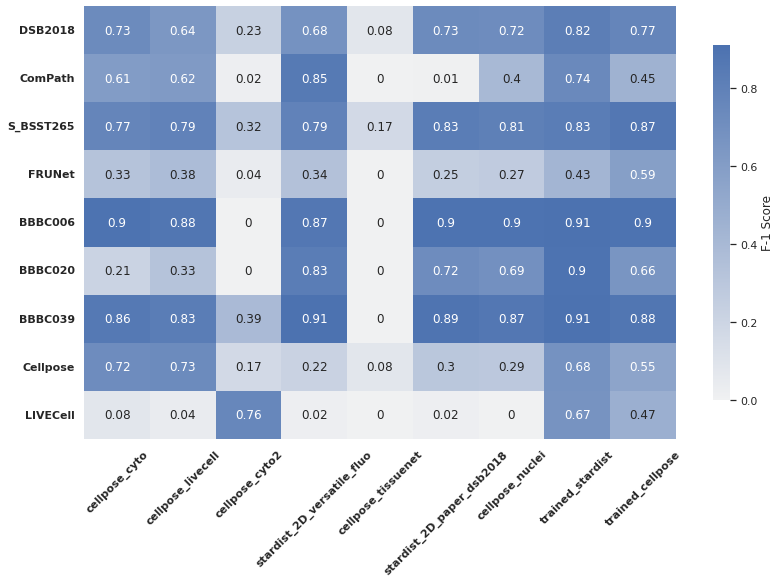

In [11]:
sns.set_theme(style="ticks", color_codes=True)
coolwarm = sns.color_palette("coolwarm_r", as_cmap=True)
mono = sns.color_palette("light:b", as_cmap=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.heatmap(heat, cmap= mono, xticklabels= table_f1.columns.drop("Name"), yticklabels= table_f1.Name, annot=True, cbar_kws={'label': 'F-1 Score', "shrink": .82,})
plot.set_xticklabels(plot.get_xticklabels(),rotation=45, fontweight = 'bold')
plot.set_yticklabels(plot.get_yticklabels(), fontweight = 'bold')
plt.tight_layout()
plt.show()